In [1]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
# Database connection details
host = '<your db>'
user = '<root>'
port = 3306
password = '<yourpassword>'
database = '<yourdb>'

# Establish connection
connection = pymysql.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

# Function to load data from a table
def load_data_from_db(connection, table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, connection)

# Load training and testing data
training_data = load_data_from_db(connection, 'training_data')
testing_data = load_data_from_db(connection, 'testing_data')

# Close the connection
connection.close()

C:\Users\kevin\AppData\Local\Temp\ipykernel_24212\159293122.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection)


In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   home                          22 non-null     int64          
 1   away                          22 non-null     int64          
 2   home_win_probability          22 non-null     float64        
 3   draw_probability              22 non-null     float64        
 4   away_win_probability          22 non-null     float64        
 5   team_to_win_prediction        22 non-null     int64          
 6   average_goals_prediction      22 non-null     float64        
 7   weather_in_degrees            22 non-null     object         
 8   odds                          22 non-null     float64        
 9   full_time_score               22 non-null     object         
 10  score_at_halftime             22 non-null     object         
 11  date                 

In [4]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   home                          20 non-null     int64          
 1   away                          20 non-null     int64          
 2   home_win_probability          20 non-null     float64        
 3   draw_probability              20 non-null     float64        
 4   away_win_probability          20 non-null     float64        
 5   team_to_win_prediction        20 non-null     int64          
 6   scoreline_prediction          20 non-null     object         
 7   average_goals_prediction      20 non-null     float64        
 8   weather_in_degrees            20 non-null     object         
 9   odds                          20 non-null     float64        
 10  date                          20 non-null     datetime64[ns] 
 11  time                 

In [5]:
testing_data.shape

(20, 35)

In [6]:
# Drop unnecessary columns
training_data_columns_to_drop = ['full_time_score', 'score_at_halftime',           
   "home_team_full_time_score",
   "away_team_full_time_score" ,             
   "home_team_halftime_score" ,          
   "away_team_halftime_score" ]
training_data = training_data.drop(columns=training_data_columns_to_drop, axis =1)

In [7]:
# Separate minority and majority classes
loss = training_data[training_data['prediction_result']==0]
win = training_data[training_data['prediction_result']==1]

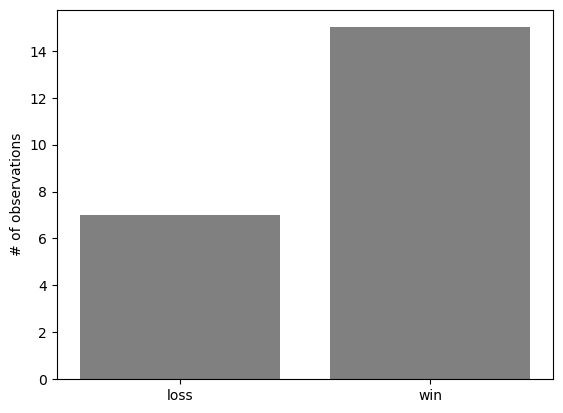

In [8]:
import matplotlib.pyplot as plt
labels = training_data['prediction_result'].unique()
heights = [len(win),len(loss)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['win','loss'])
plt.ylabel("# of observations")
plt.show()

In [9]:
loss_upsampled = resample(loss,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(win), # match number in minority class
                          random_state=27) # reproducible results

# Combine upsampled minority class with majority class
upsampled = pd.concat([loss_upsampled, win])

# Check new class counts
upsampled['prediction_result'].value_counts()

prediction_result
0    15
1    15
Name: count, dtype: int64

In [10]:
X = upsampled.drop(columns=['prediction_result', 'weather_in_degrees','date','time'])
# Define your target variable y
y = upsampled['prediction_result']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=10000, solver='saga')

# Train the model on the training data
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get more detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



In [11]:
# Create a pipeline with StandardScaler and LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=10000))  # Set max_iter here
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10],# Example values for C
    'logistic__penalty': ['l1', 'l2'],
    'logistic__solver': ['liblinear', 'saga'],
}

# Create GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Access the best parameters
best_params = grid_search.best_params_

# Access the best estimator
best_estimator = grid_search.best_estimator_


# Access the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Optionally, evaluate the performance of the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Best Parameters: {'logistic__C': 0.01, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}
Test Accuracy: 0.6666666666666666


In [12]:
# Now ill use the best parameters to create the logistic regression model
best_logistic = LogisticRegression(C=best_params['logistic__C'],
                                    penalty=best_params['logistic__penalty'],
                                    solver=best_params['logistic__solver'],
                                    max_iter=10000)
# Fit the model on the training data
best_logistic.fit(X_train, y_train)

# Predict the target variable on the testing set
y_pred = best_logistic.predict(X_test)

# Generate a classification report
test_accuracy = accuracy_score(y_pred, y_test)
print("Test Accuracy:", test_accuracy)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)


Test Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



My hunch is, when we resampled the data, we made duplicates to account for the imbalance, this created overfitting in the model. But still found the best parameters. So when we finally train without the resampled data, we are getting a higher result because there  are no duplicates and each document is unique within the data. OR it could be due to fact that the best estimator was generated after scaling through data in the pipeline. So there may be discrepancies there as well


In [13]:
# Use the best parameters to create the logistic regression model
best_logistic = LogisticRegression(C=best_params['logistic__C'],
                                    penalty=best_params['logistic__penalty'],
                                    solver=best_params['logistic__solver'],
                                    max_iter=10000)
# Fit the model on the training data
best_logistic.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing set
y_pred = best_logistic.predict(X_test)

# Generate a classification report
test_accuracy = accuracy_score(y_pred, y_test)
print("Test Accuracy:", test_accuracy)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)


Test Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



Note:
Within our Pipeline i scaled and resampled the the data this resulted in a lower accuracy and f1-score
However without scaling and sticking to only resampling (to account for imbalance) i get a higher accuracy. 


To be honest scaling, normalization and reading classification reports are my weakness. Sometimes i know there are better metrics to test my models but i usually just rely on accuracy and f1-scores. so if youre good at finding better metrics(AUC, ROC Curves etc) or better ways to tune models before testing them email me kevinocansey11@gmail.com

But for this analysis, ive decided to refrain from scaling my data.
The drawback is, if theres alot of variance in the data it will lead to lower accuracy later when introduced to new data  

But this is just a few data. As the data grows we will edit and adjust accordingly

Hence the final training for my model is below.

In [14]:
from sklearn.feature_selection import RFE

# Create logistic regression model
best_logistic = LogisticRegression(C=best_params['logistic__C'],
                                    penalty=best_params['logistic__penalty'],
                                    solver=best_params['logistic__solver'],
                                    max_iter=10000)

# Initialize RFE
rfe = RFE(estimator=best_logistic, n_features_to_select=20, step=1)

# Fit RFE
rfe.fit(X_train_resampled, y_train_resampled)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Classification Report:")
print(report)

print("Selected Features:")
print(selected_features)


Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

Selected Features:
Index(['home', 'away', 'home_win_probability', 'draw_probability',
       'away_win_probability', 'team_to_win_prediction', 'odds',
       'away_team_score_prediction', 'weekly_round', 'home_team_pos',
       'home_team_matches_played', 'home_team_draws', 'home_team_losses',
       'home_team_gf', 'home_team_ga', 'away_team_pos',
       'away_team_matches_played', 'away_team_losses', 'away_team_gf',
       'away_team_ga'],
      dtype='object')


### Its time for Validation

We tested our model with `training_data`. But remember we have testing_data(in this case our validating data) filled with upcoming matches.
Validate the model with this data. and when the matches are finally played. you can truly see how our model faired.
We need to make sure the columns match in order to use our model to predict our testing data.
once we get our y_pred, we attach it to the testing data and look at it side by side with the completed matches we want to calculate its accuracy

In [15]:
X_train_resampled.columns

Index(['home', 'away', 'home_win_probability', 'draw_probability',
       'away_win_probability', 'team_to_win_prediction',
       'average_goals_prediction', 'odds', 'home_team_score_prediction',
       'away_team_score_prediction', 'day_of_week', 'month', 'weekly_round',
       'home_team_pos', 'home_team_matches_played', 'home_team_wins',
       'home_team_draws', 'home_team_losses', 'home_team_gf', 'home_team_ga',
       'home_team_ppg_last_5_matches', 'home_team_points', 'away_team_pos',
       'away_team_matches_played', 'away_team_wins', 'away_team_draws',
       'away_team_losses', 'away_team_gf', 'away_team_ga',
       'away_team_ppg_last_5_matches', 'away_team_points'],
      dtype='object')

In [16]:
testing_data.columns

Index(['home', 'away', 'home_win_probability', 'draw_probability',
       'away_win_probability', 'team_to_win_prediction',
       'scoreline_prediction', 'average_goals_prediction',
       'weather_in_degrees', 'odds', 'date', 'time',
       'home_team_score_prediction', 'away_team_score_prediction',
       'day_of_week', 'month', 'weekly_round', 'home_team_pos',
       'home_team_matches_played', 'home_team_wins', 'home_team_draws',
       'home_team_losses', 'home_team_gf', 'home_team_ga',
       'home_team_ppg_last_5_matches', 'home_team_points', 'away_team_pos',
       'away_team_matches_played', 'away_team_wins', 'away_team_draws',
       'away_team_losses', 'away_team_gf', 'away_team_ga',
       'away_team_ppg_last_5_matches', 'away_team_points'],
      dtype='object')

In [17]:
testing_data= testing_data.drop(columns=['scoreline_prediction', 'weather_in_degrees','date','time'])

In [26]:
# Fit the model on the training data
best_logistic.fit(X_train_resampled, y_train_resampled)

# Predict the outcomes for the testing data using the best model
predictions = best_logistic.predict(testing_data)

# Prepare the results for better interpretation
results = testing_data.copy()
results['prediction_result'] = predictions


# Print the results
print("Predictions for the upcoming matches:")
print(results)

Predictions for the upcoming matches:
    home  away  home_win_probability  draw_probability  away_win_probability  \
0      7     2                  28.0              31.0                  41.0   
1     24    19                  33.0              17.0                  50.0   
2     23    15                  27.0              25.0                  49.0   
3      4    14                  34.0              34.0                  32.0   
4     13    20                  59.0              26.0                  16.0   
5      6     3                  49.0              27.0                  24.0   
6     12    22                  63.0              23.0                  14.0   
7     21     9                  25.0              39.0                  36.0   
8      1     8                  53.0              20.0                  27.0   
9      5    25                  38.0              33.0                  28.0   
10     7     2                  28.0              31.0                  41.0   
11

Great so we are going to verify how well our model did on the last day of the English Premier League!

we already have data and labels of our teams, so we are going to switch it around, look at the predictions our model agreed to or disagree to and see how many it gets right


Also the labels for team to win prediction are label encoded
Label Mapping: {'1': 0, '2': 1, 'X': 2} 
Meaning 0 is for home team to win 1 is for away team and draw is 2
We will have to switch this around aswell to help create a simple view


In [27]:
# Map team labels to team names
team_labels = {
    1: 'Arsenal',
    2: 'Aston Villa',
    3: 'Bournemouth',
    4: 'Brighton',
    5: 'Burnley',
    6: 'Chelsea',
    7: 'Crystal Palace',
    8: 'Everton',
    9: 'Fulham',
    10: 'Leeds Utd',
    11: 'Leicester City',
    12: 'Liverpool',
    13: 'Man City',
    14: 'Man Utd',
    15: 'Newcastle',
    16: 'Norwich',
    17: 'Sheffield',
    18: 'Southampton',
    19: 'Tottenham',
    20: 'West Ham',
    21: 'Luton',
    22: 'Wolves',
    23: 'Brentford',
    24: 'Sheffield Utd',
    25: 'Forest'
}


In [28]:
# previously in our  scraping data we label enconded `team_to_win_prediction` 
# Map labels to team home away and draw values
team_to_win_prediction_label= {0: '1', 1: '2', 2: 'X'} 

In [29]:
# Map team labels to team names in the DataFrame
results['home'] = results['home'].map(team_labels)
results['away'] = results['away'].map(team_labels)
results['team_to_win_prediction']  = results['team_to_win_prediction'].map(team_to_win_prediction_label)


# Select relevant columns
predictions = results[['home', 'away', 'team_to_win_prediction','prediction_result']]
predictions[:10] #i seem to have duplicate validation data so i have to pick the first 10

,home,away,team_to_win_prediction,prediction_result
0,Crystal Palace,Aston Villa,2,1
1,Sheffield Utd,Tottenham,2,1
2,Brentford,Newcastle,2,1
3,Brighton,Man Utd,1,0
4,Man City,West Ham,1,1
5,Chelsea,Bournemouth,1,0
6,Liverpool,Wolves,1,1
7,Luton,Fulham,X,0
8,Arsenal,Everton,1,1
9,Burnley,Forest,1,0


In [30]:
results[:10]

,home,away,home_win_probability,draw_probability,away_win_probability,team_to_win_prediction,average_goals_prediction,odds,home_team_score_prediction,away_team_score_prediction,...,away_team_pos,away_team_matches_played,away_team_wins,away_team_draws,away_team_losses,away_team_gf,away_team_ga,away_team_ppg_last_5_matches,away_team_points,prediction_result
0,Crystal Palace,Aston Villa,28.0,31.0,41.0,2,2.91,3.80,1,2,...,4,37,20,8,9,76,56,1.6,68,1
1,Sheffield Utd,Tottenham,33.0,17.0,50.0,2,3.53,1.36,1,3,...,5,37,19,6,12,71,61,0.6,63,1
2,Brentford,Newcastle,27.0,25.0,49.0,2,3.13,2.20,1,3,...,7,37,17,6,14,81,60,1.4,57,1
3,Brighton,Man Utd,34.0,34.0,32.0,1,2.88,4.00,2,1,...,8,37,17,6,14,55,58,1.4,57,0
4,Man City,West Ham,59.0,26.0,16.0,1,4.34,1.10,3,1,...,9,37,14,10,13,59,71,0.8,52,1
5,Chelsea,Bournemouth,49.0,27.0,24.0,1,2.78,1.45,2,1,...,11,37,13,9,15,53,65,1.2,48,0
6,Liverpool,Wolves,63.0,23.0,14.0,1,4.15,1.18,3,0,...,13,37,13,7,17,50,63,0.6,46,1
7,Luton,Fulham,25.0,39.0,36.0,X,3.43,3.90,2,2,...,14,37,12,8,17,51,59,1.0,44,0
8,Arsenal,Everton,53.0,20.0,27.0,1,3.16,1.18,3,1,...,15,37,13,9,15,39,49,2.6,40,1
9,Burnley,Forest,38.0,33.0,28.0,1,2.98,2.90,2,1,...,17,37,8,9,20,47,66,0.8,29,0


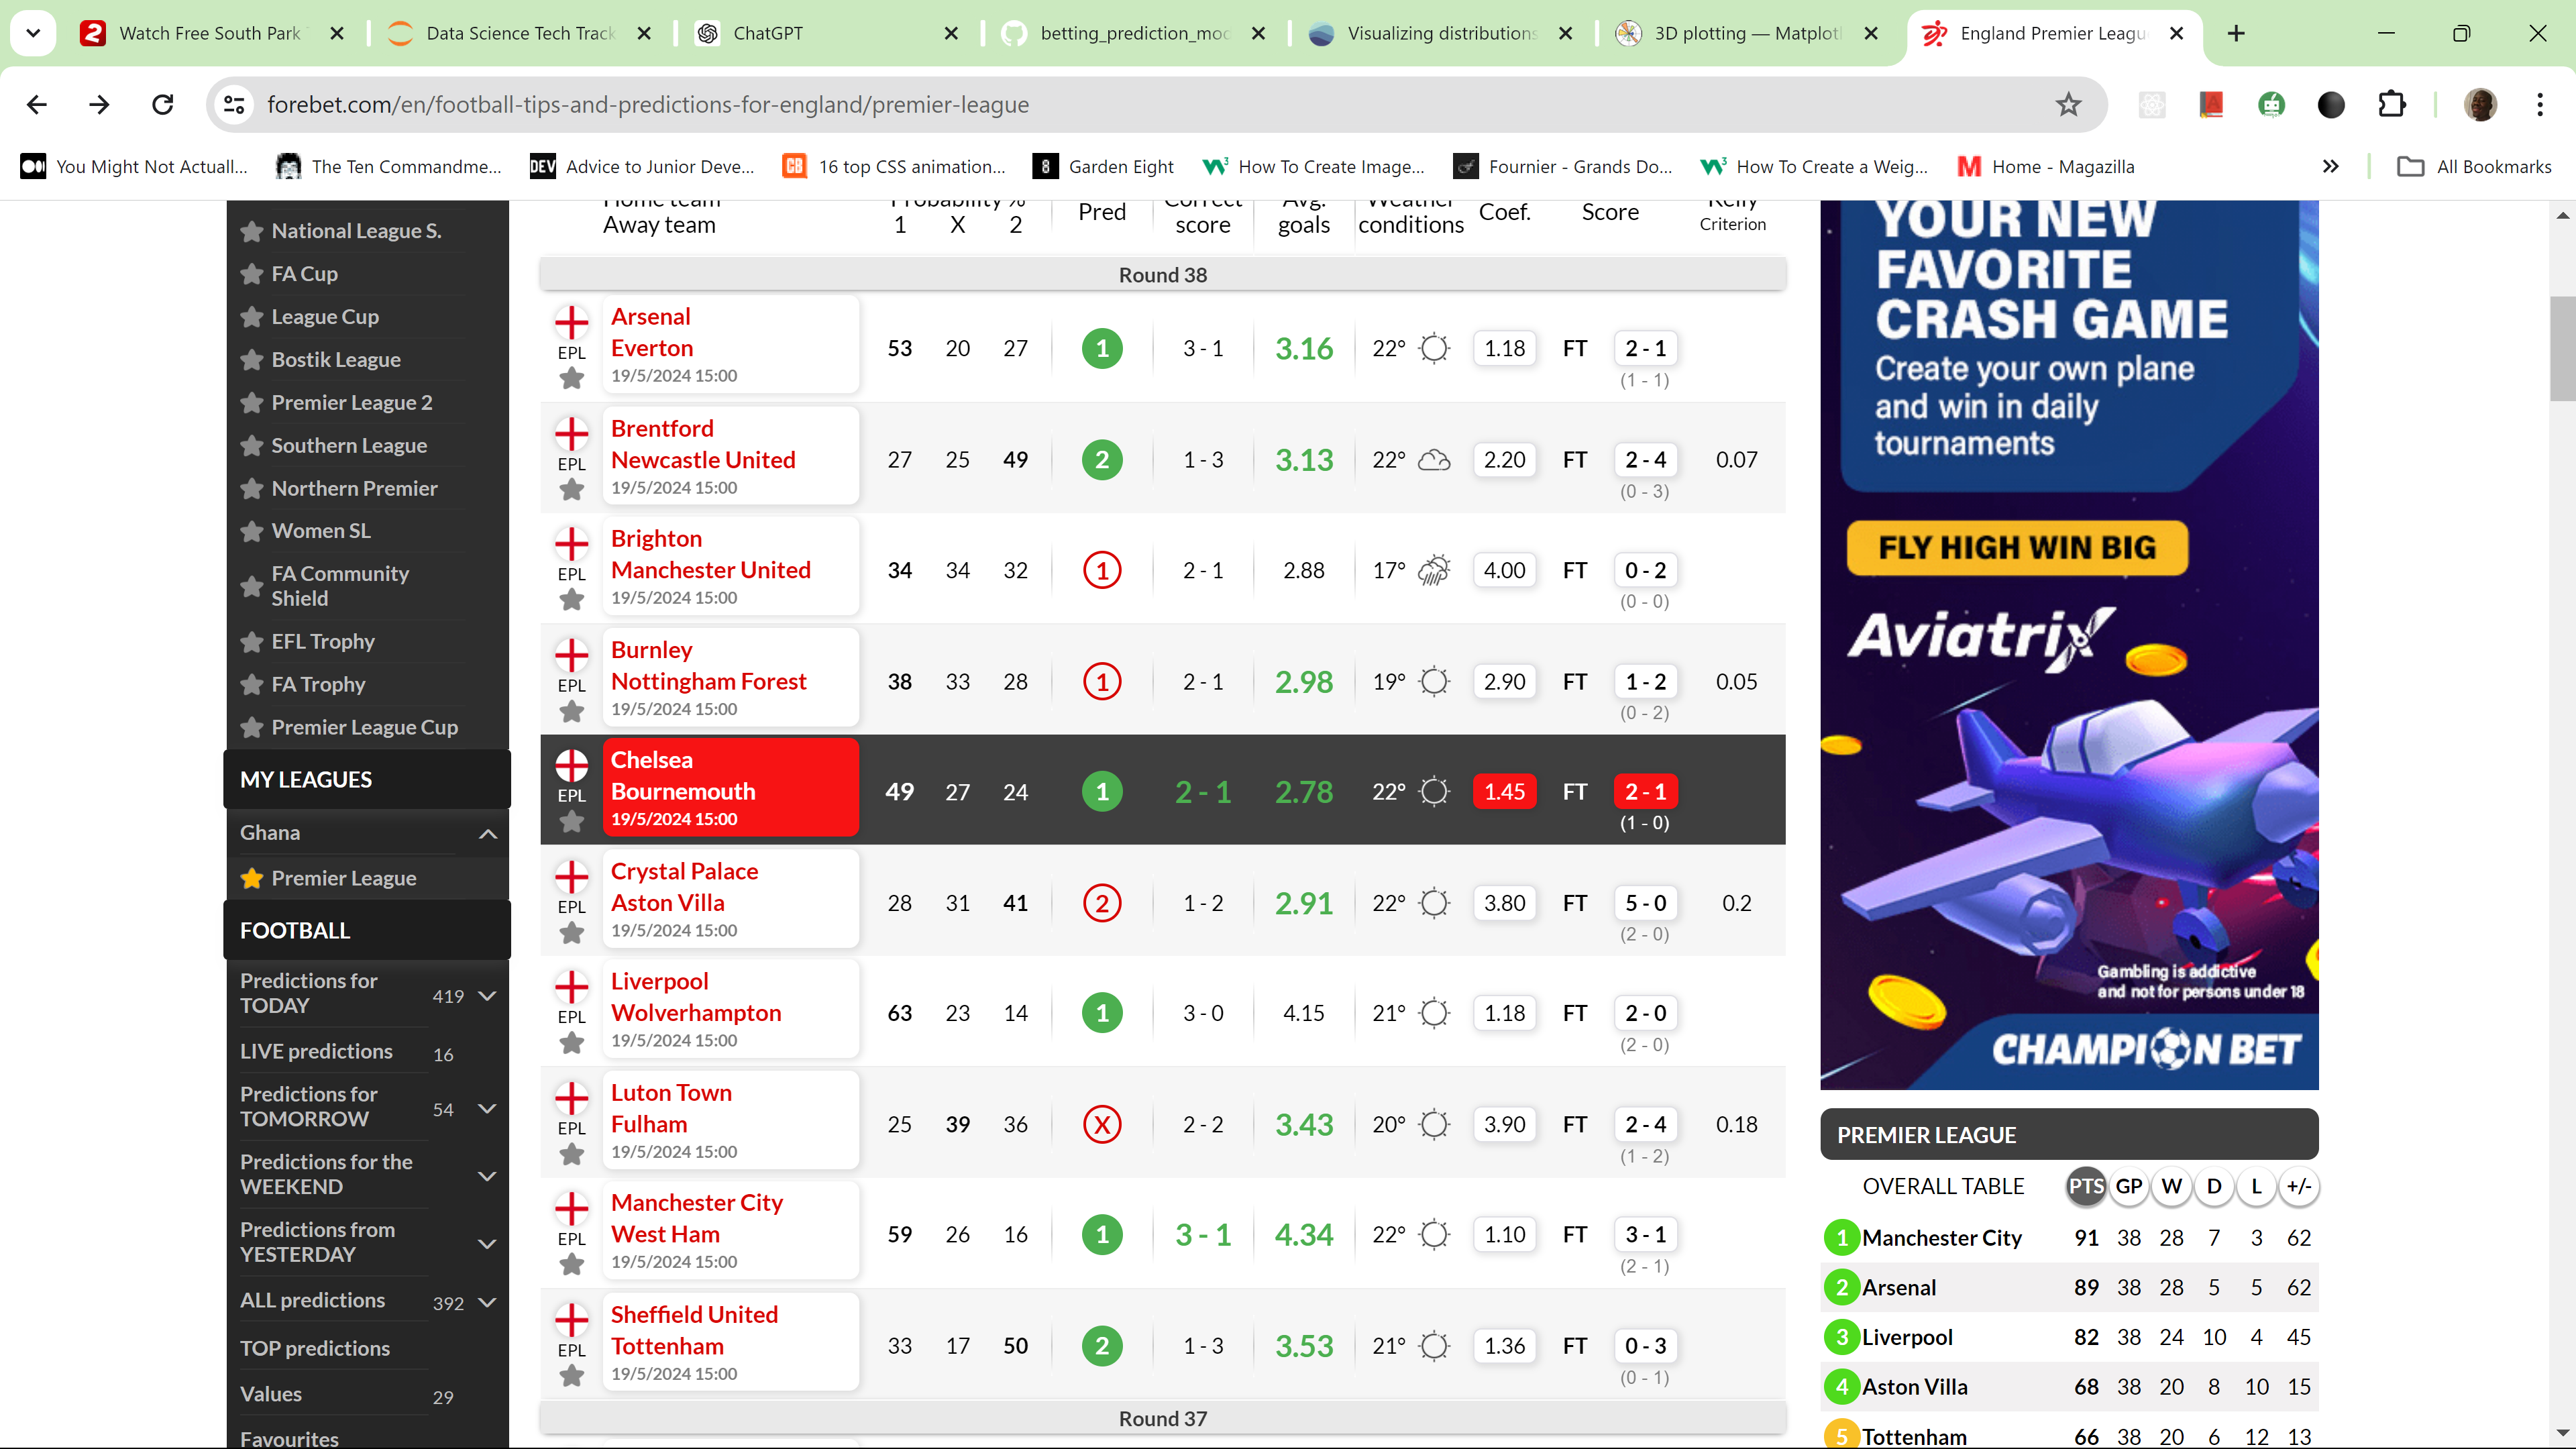

[0,1,1,1,1,0,1,1,1,1]

- Crystal Palace   v	Aston Villa	: 
Model agreed on the prediction and got it wrong

- Sheffield Utd  v	Tottenham	:    
Model agreed on the prediction and got it right

- Brentford  v Newcastle	:         
Model agreed on the prediction and got it right

- Brighton  v	Man Utd	    :        
Model disagreed on the prediction and got it right

- Man City  v	West Ham    :	     
Model agreed on the prediction and got it right

- Chelsea  v	Bournemouth	:        
Model disagreed on the prediction but got it wrong

- Liverpool v	Wolves      :        
Model agreed on the prediction and got it right

- Luton  v	Fulham          :        
Model disagreed on the prediction and got it right

- Arsenal  v	Everton	    :         
Model agreed on the prediction and got it right


##### The model got 8/10 correct
- it agreed with 6 tips and got them right
- it disagreed with one tip and got it right
- I am more excited when it disagrees with tips and gets them right than when it agrees and gets them right.

### Note to self
I will work on an automated way to test validated datas accuracy

## Conclusion

The Model with little data is able to sniff out which betting tips are okay and which ones are not.  
Although i have scraped this completed matches into my database, i have not yet added it to my training, and do not intend to until i finish with other models like svm and random forest. 
Alot can be said about the model 
So far it just either confirms whether a tip is risky or not, but it does not however give you a better prediction. 


- Also it is limited to Forebet.com data because i use their data to study their win and loss patterns
- Please be use it caution.